# 데이터를 어떻게 만들어둬야할까..

In [2]:
import os
import cv2
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn.functional as F

In [3]:
def open_file(path):
    if 'json' in path:
        with open(path, 'r') as f:
            out = json.load(f)
    elif 'pickle' in path:
        with open(path, 'rb') as f:
            out = pickle.load(f)
    elif 'jpg' in path:
        out = Image.open(path).convert("RGB")
    
    return out

In [4]:
data_path = '/media/jaeho/SSD/datasets/deepfashion/preprocessed_data/preprocessed_data.pickle'
preprocessed_data = open_file(data_path)

In [5]:
for img_path, img_info in preprocessed_data.items():
    print(img_path)
    print(img_info.keys())
    break

img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
dict_keys(['attr', 'bbox', 'category', 'landmark'])


일단 파일경로를 Key값으로 갖고, 그에 대한 정보들을 Dict형태로 값이 존재  
  
공통적으로 들어가는 입력은 Image, 하지만 그에 대해서 함께 들어가는 label은 다르다
=> image_path + bbox  
  

- shape biased => landmark
    - input_label => landmark
- texture biased => 그냥 이미지와 label..
    - input_label => attr, category
    
총 4개의 Loss를 이용해야하고, 각 stream마다 두개씩  


## 1. category (texture biased)

In [27]:
cat_label = img_info['category']

모델의 결과를 softmax로 표현 vs 기존의 category를 원핫으로 변경  
  
생각해볼 것은... softmax라고는 적혀있는데 결론적으로 사용할 loss는?  
카테고리는 늘 싱글라벨인가?

In [28]:
cat_label

[3]

In [113]:
F.one_hot(torch.LongTensor(cat_label), 46)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

카테고리 정보를 Long tensor로 변환 후, num_class (46)를 이용해서 Onehot 인코딩해서 gt값 생성  
1 to k classification problem

## 2. attribute (texture biased)
- sigmoid cross-entropy loss..
- Multi label task
- 1 => possitive, -1 => negative, 0 => unknown
    - Unknown은 어떻게 처리를 하냐 그럼..

In [109]:
torch.Tensor([1 if x == 1 else 0 for x in img_info['attr']])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [30]:
len(img_info['attr'])

1000

In [31]:
from collections import Counter
Counter(img_info['attr'])

Counter({-1: 996, 1: 4})

이것도 따로 처리할 건 없고 라벨 그대로 사용하면.. 될것

---

## 3. landmark visibility


In [32]:
landmark_info = img_info['landmark']
landmark_info

defaultdict(list,
            {'left_collar': [1, 102, 106],
             'right_collar': [0, 116, 102],
             'left_sleeve': [0, 63, 194],
             'right_sleeve': [1, 146, 216],
             'left_hem': [0, 105, 245],
             'right_hem': [0, 137, 246]})

In [33]:
landmark_map = ["left collar", "right collar", "left sleeve", "right sleeve", "left waistline", "right waistline", "left hem", "right hem"]
landmark_map = [x.replace(" ", "_") for x in landmark_map]

In [34]:
landmark_map

['left_collar',
 'right_collar',
 'left_sleeve',
 'right_sleeve',
 'left_waistline',
 'right_waistline',
 'left_hem',
 'right_hem']

In [186]:
visibility_list = []
for lm in landmark_map:
    if lm in landmark_info:
        visibility_list.append(1 if landmark_info[lm][0] == 0 else 0)
    else :
        visibility_list.append(0)
visibility_list

[0, 1, 1, 0, 0, 0, 1, 1]

In [187]:
landmark_info

defaultdict(list,
            {'left_collar': [1, 102, 106],
             'right_collar': [0, 116, 102],
             'left_sleeve': [0, 63, 194],
             'right_sleeve': [1, 146, 216],
             'left_hem': [0, 105, 245],
             'right_hem': [0, 137, 246]})

In [188]:
target_img_dir = '/media/jaeho/SSD/datasets/deepfashion/img-001/'

In [189]:
img_path

'img/Sheer_Pleated-Front_Blouse/img_00000005.jpg'

In [190]:
target_img_path = os.path.join(target_img_dir, img_path)
target_img_path

'/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000005.jpg'

In [191]:
img_obj = open_file(target_img_path)

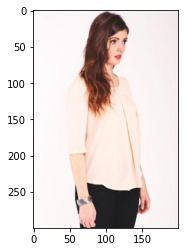

In [192]:
plt.imshow(img_obj)

## 4. landmark map
일반적으로 landmark detection은 어떻게 하는 거지?
1. 이미지 입력 --> landmark Detection?
2. 이미지에 Landmark를 얹어서..?  
  
다른 예제를 보면 그냥 이미지를 넣고 바로 Landmark와 loss를 구해서 학습을 한다.  
그러면 이후에 이때... gt는 단순히 하나의 점이 아니라 가우시안 필터를 이용해서 생성하는 거고..

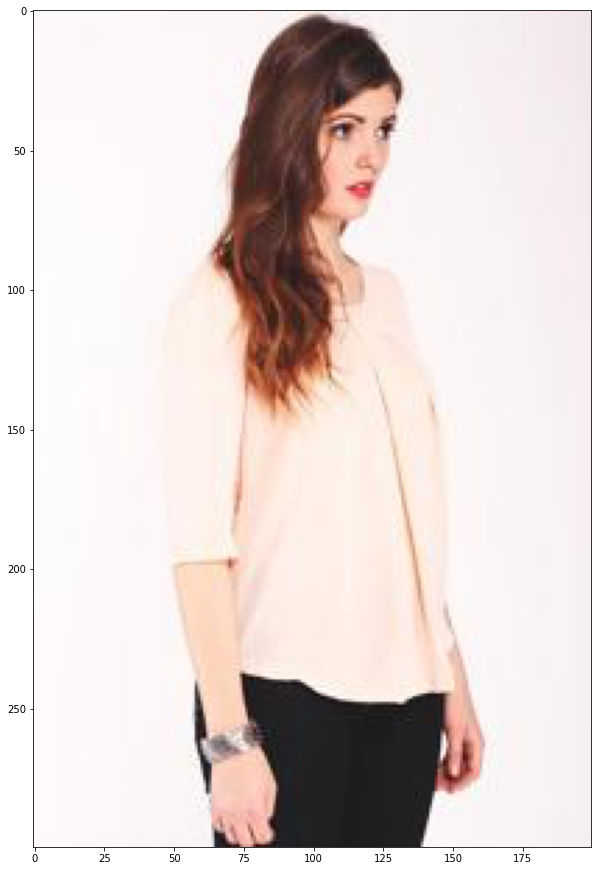

In [193]:
plt.figure(figsize=(10, 20))
plt.imshow(img_obj)
plt.show()

In [194]:
img_info.keys()

dict_keys(['attr', 'bbox', 'category', 'landmark'])

In [195]:
target_img_path

'/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000005.jpg'

In [196]:
bbox = img_info['bbox']
bbox

[46, 88, 166, 262]

In [197]:
cropped_img = img_obj.crop(bbox)

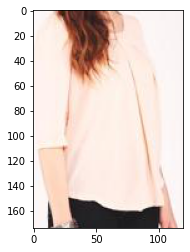

In [198]:
plt.imshow(cropped_img)
plt.show()

landmark를 위 그림에서 찍어보자

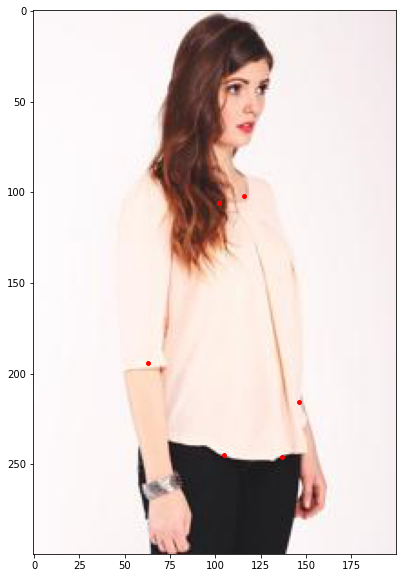

In [199]:
plt.figure(figsize=(10, 10))
plt.imshow(img_obj)
for key, l_i in landmark_info.items():
    visibility, x, y = l_i
    plt.scatter(x, y, s=15, c='r')
plt.show()

In [200]:
img_info['landmark']

defaultdict(list,
            {'left_collar': [1, 102, 106],
             'right_collar': [0, 116, 102],
             'left_sleeve': [0, 63, 194],
             'right_sleeve': [1, 146, 216],
             'left_hem': [0, 105, 245],
             'right_hem': [0, 137, 246]})

In [201]:
landmark_info.get('left_collar')

[1, 102, 106]

In [202]:
landmark_map

['left_collar',
 'right_collar',
 'left_sleeve',
 'right_sleeve',
 'left_waistline',
 'right_waistline',
 'left_hem',
 'right_hem']

In [203]:
landmark_info

defaultdict(list,
            {'left_collar': [1, 102, 106],
             'right_collar': [0, 116, 102],
             'left_sleeve': [0, 63, 194],
             'right_sleeve': [1, 146, 216],
             'left_hem': [0, 105, 245],
             'right_hem': [0, 137, 246]})

In [204]:
np.array([[0] if x in landmark_info else [1] for x in landmark_map]).shape

(8, 1)

crop하지 않은 이미지와 landmark 좌표가 대응이 된다.

In [205]:
height, width = img_obj.size
width, height

(300, 200)

In [206]:
zero_map = np.zeros(img_obj.size)

In [207]:
width, height

(300, 200)

In [208]:
for idx, l_name in enumerate(landmark_map):
    
    mask = np.zeros(img_obj.size)

    if l_name in landmark_info:
        visibility, x, y = landmark_info.get(l_name)
        if visibility == 0:
            mask[x][y] = 255
    
    mask = mask.reshape((1, width, height))
    
    if idx == 0:
        img_mask = mask
    else :
        img_mask = np.concatenate((img_mask, mask), axis=0)

In [209]:
img_mask.shape

(8, 300, 200)

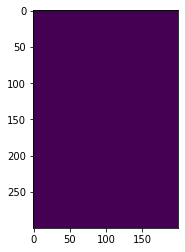

In [210]:
plt.imshow(img_mask[0])    

In [211]:
nof_joints = 8

In [212]:
target = np.zeros((nof_joints, width, height), dtype=np.float32)

joints_vis는 visibility에 대해서 나와있는건데..

In [213]:
joints_vis = np.array([[x] for x in visibility_list])
# joints_vis=np.array([[1], [1], [1], [1], [0], [0], [1], [1]])
joints_vis.shape

(8, 1)

In [214]:
joints_vis

array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [215]:
target_weight = np.ones((nof_joints, 1), dtype=np.float32)
# target_weight[:, 0] = joints_vis[:, 0]  # joints_vis

joints = [landmark_info[x][1:] if x in landmark_info else [0, 0] for x in landmark_map]
joints = np.array(joints, dtype=np.float)

heatmap_size = (width, height)
img_size = (width, height)
heatmap_sigma=3
tmp_size = heatmap_sigma * 3

/home/jaeho/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [216]:
joints

array([[102., 106.],
       [116., 102.],
       [ 63., 194.],
       [146., 216.],
       [  0.,   0.],
       [  0.,   0.],
       [105., 245.],
       [137., 246.]])

In [217]:
for joint_id in range(nof_joints):
    print(target[joint_id].shape)
    feat_stride = np.asarray(img_size) / np.asarray(heatmap_size)
    print(f"feat_stride : {feat_stride}")
    mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
    mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
    print(f"mu_x : {mu_x}, mu_y : {mu_y}")
    # check that any part of the gaussian is in-bounds
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    print(f"ul : {ul}, br : {br}")
    if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] or br[0] < 0 or br[1] < 0:
        target_weight[joint_id] = 0
        continue
    
    # generate gaussian
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # the gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * heatmap_sigma ** 2))
    
    # usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
    print(f"g_x : {g_x}, g_y : {g_y}")
    
    # image range
    img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
    img_y = max(0, ul[1]), min(br[1], heatmap_size[1])
    print(f"img_x : {img_x}, img_y : {img_y}")
    
    v = target_weight[joint_id]
    if v > 0.5:
        # print(f"{img_y[0]}:{img_y[1]},{img_x[0]}:{img_x[1]}")
        # print(f"{g_y[0]}:{g_y[1]},{g_x[0]}:{g_x[1]}")
        # print(target[joint_id][img_y[0] : img_y[1], img_x[0]:img_x[1]])
        # print(target[joint_id][img_y[0] : img_y[1], img_x[0]:img_x[1]].shape)
        # print(g[g_y[0]:g_y[1], g_x[0]:g_x[1]].shape)
        target[joint_id][img_y[0] : img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    print()

(300, 200)
feat_stride : [1. 1.]
mu_x : 102, mu_y : 106
ul : [93, 97], br : [112, 116]
g_x : (0, 19), g_y : (0, 19)
img_x : (93, 112), img_y : (97, 116)

(300, 200)
feat_stride : [1. 1.]
mu_x : 116, mu_y : 102
ul : [107, 93], br : [126, 112]
g_x : (0, 19), g_y : (0, 19)
img_x : (107, 126), img_y : (93, 112)

(300, 200)
feat_stride : [1. 1.]
mu_x : 63, mu_y : 194
ul : [54, 185], br : [73, 204]
g_x : (0, 19), g_y : (0, 15)
img_x : (54, 73), img_y : (185, 200)

(300, 200)
feat_stride : [1. 1.]
mu_x : 146, mu_y : 216
ul : [137, 207], br : [156, 226]
(300, 200)
feat_stride : [1. 1.]
mu_x : 0, mu_y : 0
ul : [-9, -9], br : [10, 10]
g_x : (9, 19), g_y : (9, 19)
img_x : (0, 10), img_y : (0, 10)

(300, 200)
feat_stride : [1. 1.]
mu_x : 0, mu_y : 0
ul : [-9, -9], br : [10, 10]
g_x : (9, 19), g_y : (9, 19)
img_x : (0, 10), img_y : (0, 10)

(300, 200)
feat_stride : [1. 1.]
mu_x : 105, mu_y : 245
ul : [96, 236], br : [115, 255]
(300, 200)
feat_stride : [1. 1.]
mu_x : 137, mu_y : 246
ul : [128, 237],

In [218]:
np.max(target[0])

1.0

In [219]:
np.min(target[0])

0.0

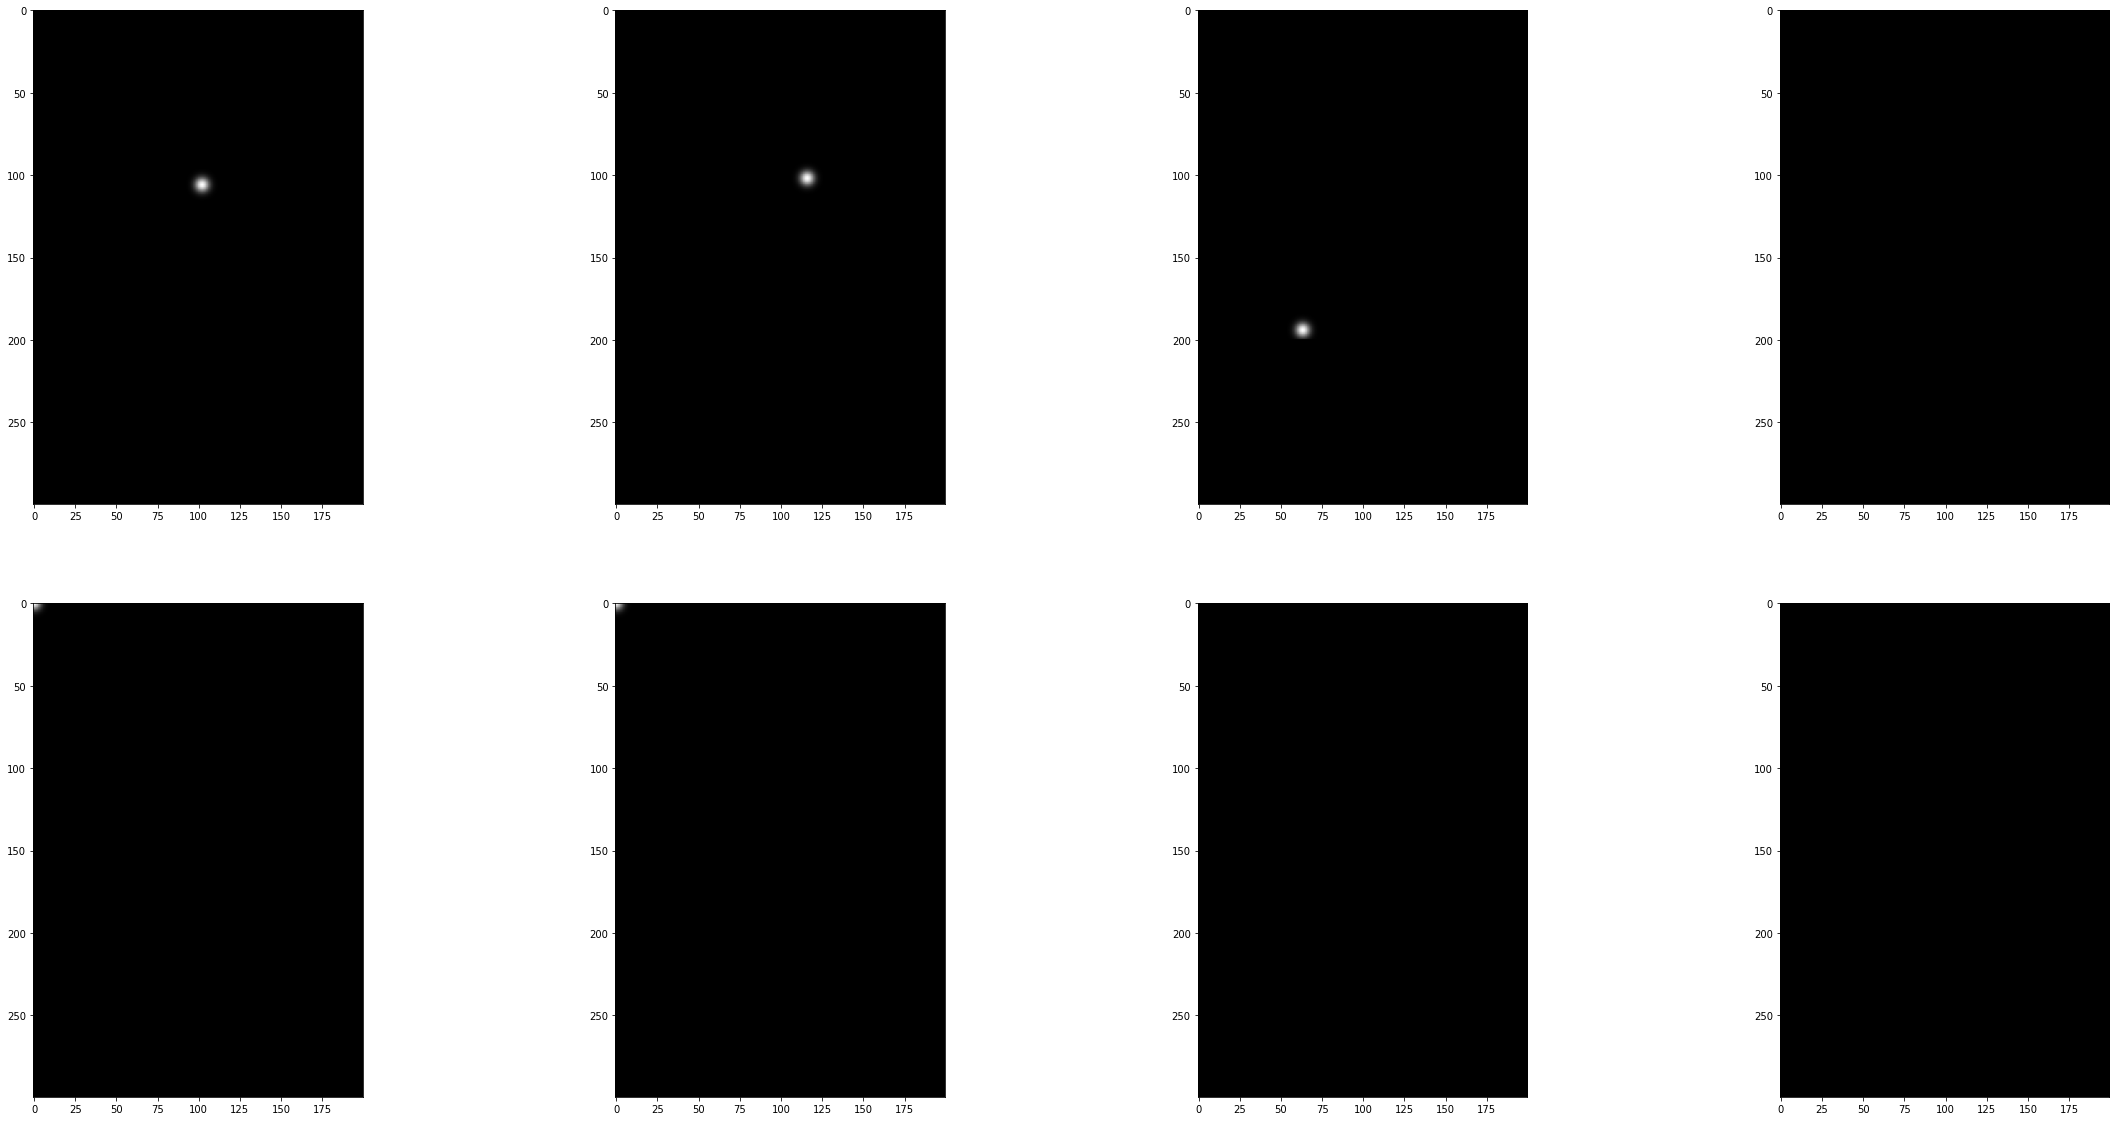

In [220]:
plt.figure(figsize=(40, 20))
for idx, t in enumerate(target):
    plt.subplot(2, 4, idx+1)
    plt.imshow(t, cmap='gray', vmin=0, vmax=1)
plt.show()

위 처럼 채널별로 만들면.. 되는 거겠지?  
가우시안 필터를 적용시킬 때, 입력으로 들어갈 하이퍼파라미터 정도는 알아봐야 할 것 같음

In [103]:
img_obj.size

(200, 300)

In [221]:
check_img = np.zeros(dtype=np.float32, shape=(300,200))
# import copy
# check_img = copy.deepcopy(img_obj)
# check_img = np.array(check_img)

In [222]:
check_img = np.zeros(dtype=np.float32, shape=(300,200))

for k, w in enumerate(target):
    # print(k)
    # print(w.shape)
    check_img += w

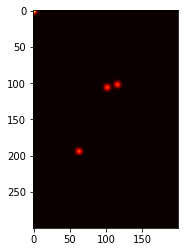

In [223]:
plt.imshow(check_img, cmap='hot')
plt.show()

In [224]:
# plt.imshow(heatmap_img)
# plt.show()

In [225]:
heatmap_img = np.array([check_img,check_img,check_img])
heatmap_img = np.transpose(heatmap_img, (1, 2, 0)).astype(np.float)

heatmap_img.shape

/home/jaeho/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(300, 200, 3)

In [226]:
new_h_m = np.stack([check_img*255]*3, axis=-1).astype(np.uint8)

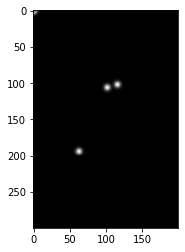

In [227]:
plt.imshow(new_h_m)
plt.show()

In [228]:
np.max(heatmap_img[:, :, 2])

2.0

In [229]:
origin_image = np.array(img_obj).astype(np.uint8)
# origin_image = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
# cam_img_int = 255*heatmap_img.astype(np.uint8)
cam_heat = cv2.applyColorMap(new_h_m, cv2.COLORMAP_JET)
cam_heat = cv2.cvtColor(cam_heat, cv2.COLOR_RGB2BGR)


In [230]:
alpha = 0.3
beta = 1 - alpha

In [231]:
new_img = cv2.addWeighted(cam_heat, alpha, origin_image, beta, 0)

In [232]:
np.max(new_img)

255

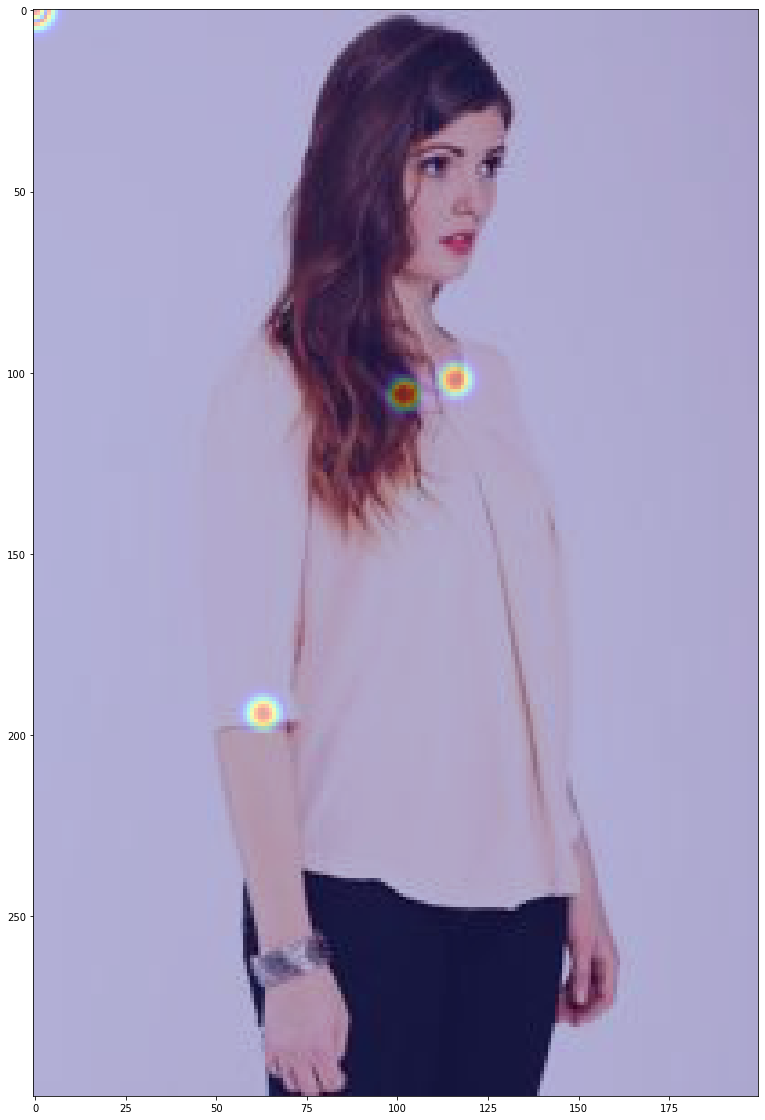

In [233]:
plt.figure(figsize=(20, 20))
plt.imshow(new_img)
plt.show()

In [10]:
list(preprocessed_data.items())[3][0]

'img/Sheer_Pleated-Front_Blouse/img_00000004.jpg'

In [12]:
list(preprocessed_data.items())[4][0]

'img/Sheer_Pleated-Front_Blouse/img_00000005.jpg'

In [24]:
check_data = list(preprocessed_data.items())[4]

In [26]:
img_path = check_data[0]
img_info = check_data[1]

In [15]:
print(img_path)

img/Sheer_Pleated-Front_Blouse/img_00000005.jpg


In [19]:
img = Image.open(os.path.join('/media/jaeho/SSD/datasets/deepfashion/img-001', img_path))

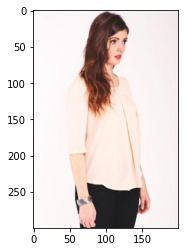

In [20]:
plt.imshow(img)
plt.show()

In [23]:
infos['landmark']

defaultdict(list,
            {'left_collar': [1, 102, 106],
             'right_collar': [0, 116, 102],
             'left_sleeve': [0, 63, 194],
             'right_sleeve': [1, 146, 216],
             'left_hem': [0, 105, 245],
             'right_hem': [0, 137, 246]})

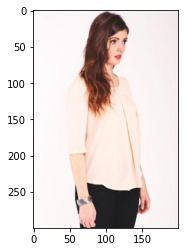

In [118]:
plt.imshow(img)

In [123]:
bbox = infos['bbox']
bbox

[46, 88, 166, 262]

In [121]:
img_array = np.array(img)

In [129]:
bbox[3] - bbox[1], bbox[2] - bbox[0]

(174, 120)

In [126]:
cropped = img_array[bbox[1]:bbox[3], bbox[0]:bbox[2]]

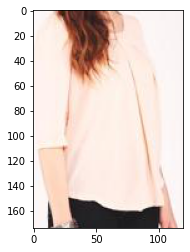

In [127]:
plt.imshow(cropped)
plt.show()

In [128]:
cropped.shape

(174, 120, 3)

In [266]:
target.shape

(8, 300, 200)

In [270]:
cropped_target_2 = target[..., bbox[1]:bbox[3], bbox[0]:bbox[2]]

In [271]:
cropped_target_2.shape

(8, 174, 120)

In [236]:
trans_target = np.transpose(target, (1, 2, 0))
trans_target.shape

(300, 200, 8)

In [237]:
cropped_target = trans_target[bbox[1]:bbox[3], bbox[0]:bbox[2]]

In [245]:
cropped_target.shape

(174, 120, 8)

In [248]:
trans_cropped_target = np.transpose(cropped_target, (2, 0, 1))

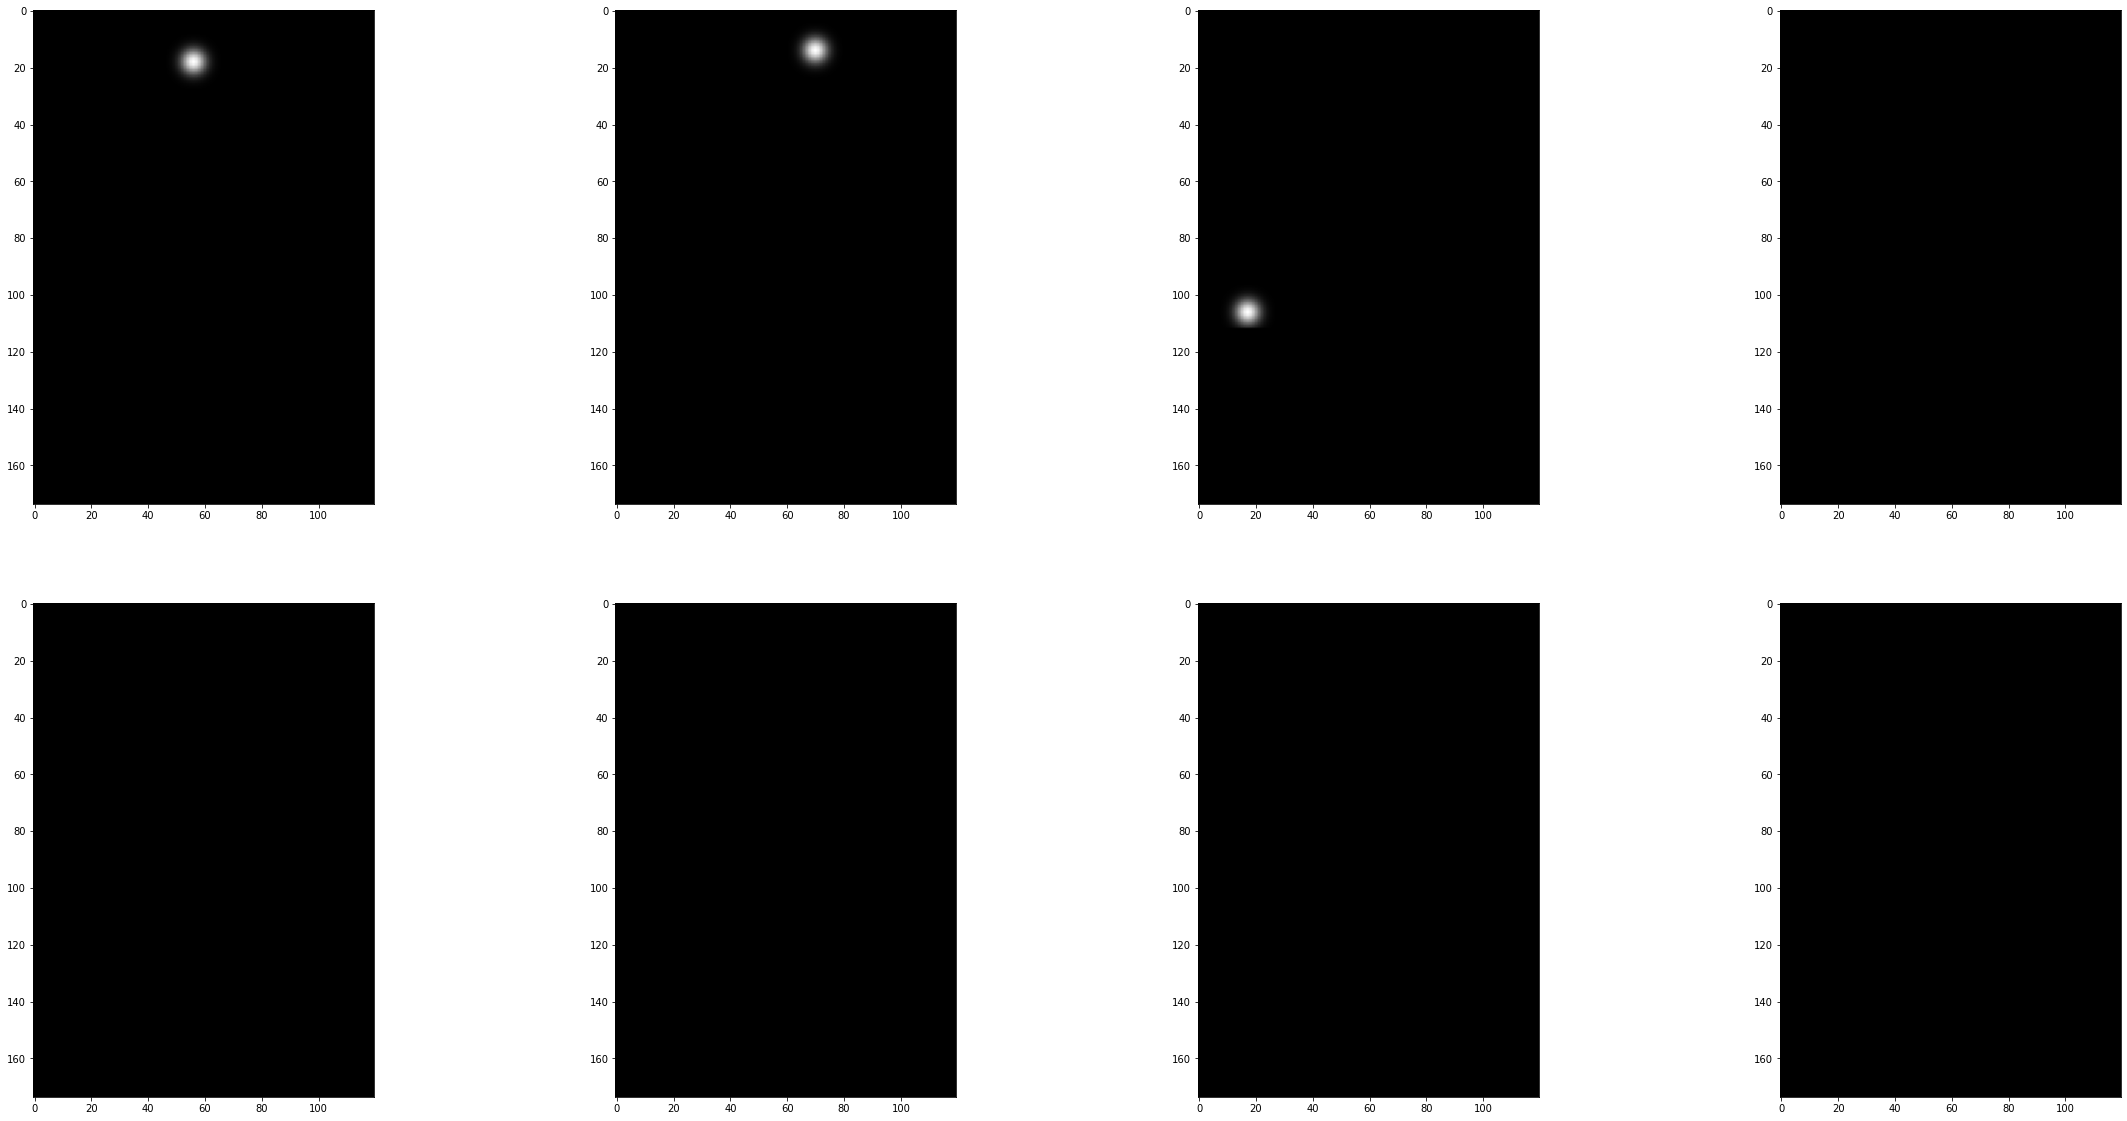

In [249]:
plt.figure(figsize=(40, 20))
for idx, t in enumerate(trans_cropped_target):
    plt.subplot(2, 4, idx+1)
    plt.imshow(t, cmap='gray', vmin=0, vmax=1)
plt.show()

In [259]:
check_img = np.zeros(dtype=np.float32, shape=(174,120))

for k, w in enumerate(trans_cropped_target):
    # print(k)
    # print(w.shape)
    check_img += w
    
new_h_m = np.stack([check_img*255]*3, axis=-1).astype(np.uint8)

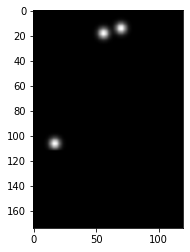

In [260]:
plt.imshow(new_h_m)

In [261]:
origin_image = cropped.astype(np.uint8)
# origin_image = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
# cam_img_int = 255*heatmap_img.astype(np.uint8)
cam_heat = cv2.applyColorMap(new_h_m, cv2.COLORMAP_JET)
cam_heat = cv2.cvtColor(cam_heat, cv2.COLOR_RGB2BGR)

new_img = cv2.addWeighted(cam_heat, alpha, origin_image, beta, 0)

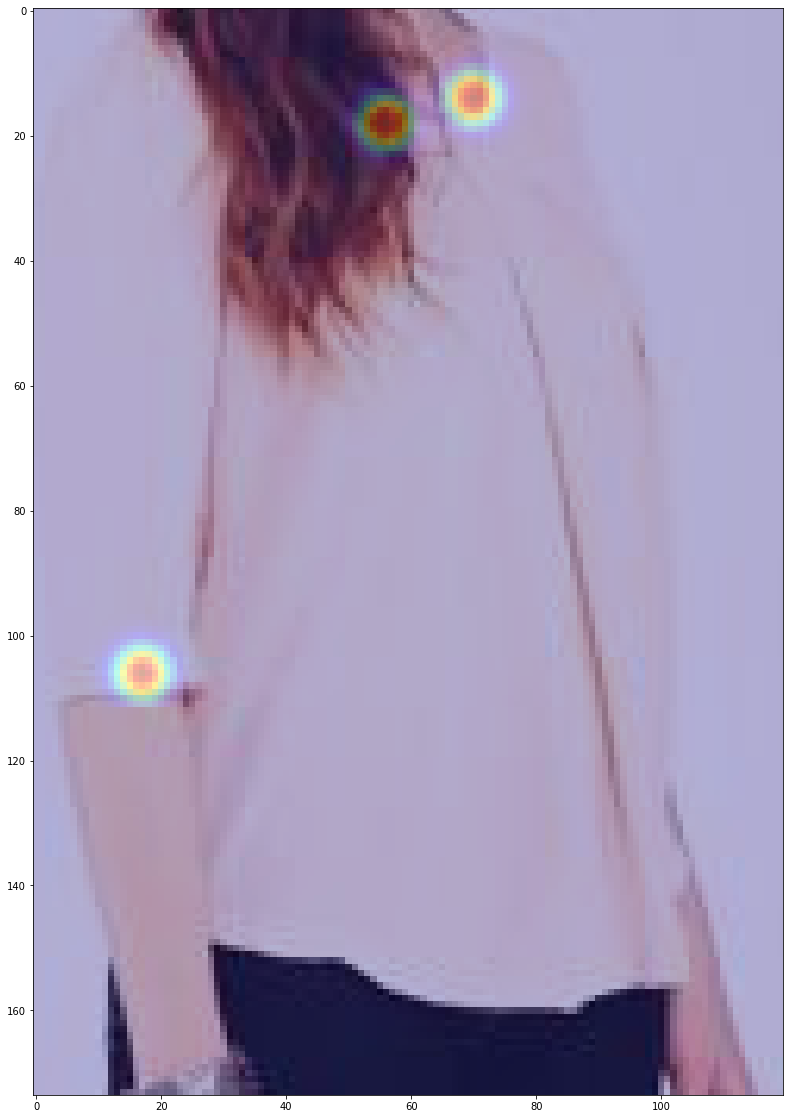

In [262]:
plt.figure(figsize=(20, 20))
plt.imshow(new_img)
plt.show()